In [37]:
!pip install matplotlib seaborn -q

In [38]:
# Global imports & constants
import json
import os
import glob
import random
from textwrap import wrap
from typing import Optional
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import savgol_filter


# --- Global Settings & Constants ---

# Plotting Style (applied globally when this module is imported)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook")
sns.set_palette("colorblind") # Use a colorblind-friendly palette

# Default Colors for plots with multiple lines/bars
# Using seaborn's colorblind palette directly for consistency
DEFAULT_COLORS = sns.color_palette("colorblind")

# Default Figure Size
DEFAULT_FIGSIZE = (12, 4)

# Map strategy prefixes to full names for titles/legends
STRATEGY_PREFIXES = {
    "random": "Random",
    "round": "Round Robin",
    "pow": "Power of 2",
    "prefix": "Prefix Aware"
}
STRATEGY_NAMES = {
    "random": "Random",
    "round_robin": "Round Robin",
    "pow_of_2": "Power of 2",
    "prefix_aware": "Prefix Aware"
}

In [39]:
# Serve and vLLM constants

AVAILABLE_SERVE_METRICS = {
    "duration": "Benchmark Duration (s)",
    # "completed": "Completed Requests",
    # "request_throughput": "Request Throughput (req/s)",
    # "input_throughput": "Input Throughput (tokens/s)",
    # "output_throughput": "Output Throughput (tokens/s)",
    "mean_ttft_ms": "Mean TTFT (ms)",
    # "median_ttft_ms": "Median TTFT (ms)",
    # "std_ttft_ms": "Std Dev TTFT (ms)",
    # "p99_ttft_ms": "P99 TTFT (ms)",
    "mean_tpot_ms": "Mean TPOT (ms)",
    # "median_tpot_ms": "Median TPOT (ms)",
    # "std_tpot_ms": "Std Dev TPOT (ms)",
    # "p99_tpot_ms": "P99 TPOT (ms)",
    # "mean_itl_ms": "Mean ITL (ms)",
    # "median_itl_ms": "Median ITL (ms)",
    # "std_itl_ms": "Std Dev ITL (ms)",
    # "p99_itl_ms": "P99 ITL (ms)",
    "mean_e2e_latency_ms": "Mean E2E Latency (ms)",
    # "median_e2e_latency_ms": "Median E2E Latency (ms)",
}

VLLM_BENCHMARK_METRICS = {
    # Saved by benchmark
    # "ray_vllm:prompt_tokens_total": "Total Prompt Tokens",
    # "ray_vllm:generation_tokens_total": "Total Generation Tokens",
    # "ray_vllm:request_success_total": "Total Successful Requests",
    # "ray_vllm:time_to_first_token_seconds": "Mean TTFT (ms)",
    # "ray_vllm:time_per_output_token_seconds": "Mean TPOT (ms)",
    # "ray_vllm:e2e_request_latency_seconds": "Mean E2E Latency (ms)",
    "ray_vllm:request_queue_time_seconds": "Mean Request Queue Time (ms)",
    # "ray_vllm:request_inference_time_seconds": "Mean Request Inference Time (ms)",
    "ray_vllm:request_prefill_time_seconds": "Mean Request Prefill Time (ms)",
    "ray_vllm:request_decode_time_seconds": "Mean Request Decode Time (ms)",
}
ALL_AVAILABLE_VLLM_METRICS = {
    # Saved by benchmark
    "ray_vllm:prompt_tokens_total": "Total Prompt Tokens",
    "ray_vllm:generation_tokens_total": "Total Generation Tokens",
    "ray_vllm:request_success_total": "Total Successful Requests",
    "ray_vllm:time_to_first_token_seconds": "Mean TTFT (ms)",
    "ray_vllm:time_per_output_token_seconds": "Mean TPOT (ms)",
    "ray_vllm:e2e_request_latency_seconds": "Mean E2E Latency (ms)",
    "ray_vllm:request_queue_time_seconds": "Mean Request Queue Time (ms)",
    "ray_vllm:request_inference_time_seconds": "Mean Request Inference Time (ms)",
    "ray_vllm:request_prefill_time_seconds": "Mean Request Prefill Time (ms)",
    "ray_vllm:request_decode_time_seconds": "Mean Request Decode Time (ms)",
    # Other metrics
    "ray_vllm:num_requests_running": "Number of Running Requests",
    "ray_vllm:num_requests_swapped": "Number of Swapped Requests",
    "ray_vllm:num_requests_waiting": "Number of Waiting Requests",
    "ray_vllm:gpu_cache_usage_perc": "GPU Cache Usage",
    "ray_vllm:cpu_cache_usage_perc": "CPU Cache Usage",
    "ray_vllm:gpu_prefix_cache_hit_rate": "GPU Prefix Cache Hit Rate",
    "ray_vllm:cpu_prefix_cache_hit_rate": "CPU Prefix Cache Hit Rate",
    "ray_vllm:iteration_tokens_total": "Total Iteration Tokens"
}

VLLM_METRIC_TYPES = {
    # Saved by benchmark
    "ray_vllm:prompt_tokens_total": "counter",
    "ray_vllm:generation_tokens_total": "counter",
    "ray_vllm:request_success_total": "counter",
    "ray_vllm:time_to_first_token_seconds": "histogram",
    "ray_vllm:time_per_output_token_seconds": "histogram",
    "ray_vllm:e2e_request_latency_seconds": "histogram",
    "ray_vllm:request_queue_time_seconds": "histogram",
    "ray_vllm:request_inference_time_seconds": "histogram",
    "ray_vllm:request_prefill_time_seconds": "histogram",
    "ray_vllm:request_decode_time_seconds": "histogram",

    # Other metrics
    "ray_vllm:num_requests_running": "gauge",
    "ray_vllm:num_requests_swapped": "gauge",
    "ray_vllm:num_requests_waiting": "gauge",
    "ray_vllm:gpu_cache_usage_perc": "gauge",
    "ray_vllm:cpu_cache_usage_perc": "gauge",
    "ray_vllm:gpu_prefix_cache_hit_rate": "gauge",
    "ray_vllm:cpu_prefix_cache_hit_rate": "gauge",
    "ray_vllm:iteration_tokens_total": "histogram",
    # "ray_vllm:lora_requests_info": "gauge",
    # "ray_vllm:request_params_n": "histogram",
    # "ray_vllm:request_params_max_tokens": "histogram",
    # "ray_vllm:time_in_queue_requests": "histogram", # Redundant with request_queue_time_seconds
    # "ray_vllm:request_prompt_tokens": "histogram", # Redundant with prompt_tokens_total
    # "ray_vllm:request_generation_tokens": "histogram", # Redundant with generation_tokens_total
    # "ray_vllm:request_max_num_generation_tokens": "histogram", # Redundant with request_generation_tokens
    # "ray_vllm:num_preemptions_total": "counter",
    # "ray_vllm:cache_config_info": "gauge",
    # "ray_vllm:tokens_total": "counter", # Redundant
    # "ray_vllm:model_forward_time_milliseconds": "histogram",
    # "ray_vllm:model_execute_time_milliseconds": "histogram",
    # "ray_vllm:spec_decode_draft_acceptance_rate": "gauge",
    # "ray_vllm:spec_decode_efficiency": "gauge",
    # "ray_vllm:spec_decode_num_accepted_tokens_total": "counter",
    # "ray_vllm:spec_decode_num_draft_tokens_total": "counter",
    # "ray_vllm:spec_decode_num_emitted_tokens_total": "counter"
}

VLLM_METRIC_SPECIAL_Y_AXIS_LIMITS = {
    "ray_vllm:gpu_cache_usage_perc": [-0.1, 1.1],
    "ray_vllm:cpu_cache_usage_perc": [-0.1, 1.1],
    "ray_vllm:gpu_prefix_cache_hit_rate": [-0.1, 1.1],
    "ray_vllm:cpu_prefix_cache_hit_rate": [-0.1, 1.1],
    "ray_vllm:num_requests_running": [-1, 21]
}

def matches_vllm_metric_name(key, metric_name, suffix=""):
    # Split the key at the '{' character and take the first part
    key_prefix = key.split("{")[0]
    # Check if the key_prefix exactly matches metric_name + suffix
    return key_prefix == metric_name + suffix

def combine_log_files(output_file_name, strategy_prefix, log_directory):
    # Create the output file path
    output_path = f"{log_directory}/{strategy_prefix}_{output_file_name}.csv"

    # Find all log files in the directory
    pattern = os.path.join(log_directory, f"{strategy_prefix}_*.csv")
    log_files = glob.glob(pattern)

    if not log_files:
        print(f"No matching log files found in {log_directory}")
        return None
    # Combine all files into one
    with open(output_path, "w") as outfile:
        for log_file in log_files:
            with open(log_file, "r") as infile:
                outfile.write(infile.read())
                # Add a newline between files if needed
                outfile.write("\n")

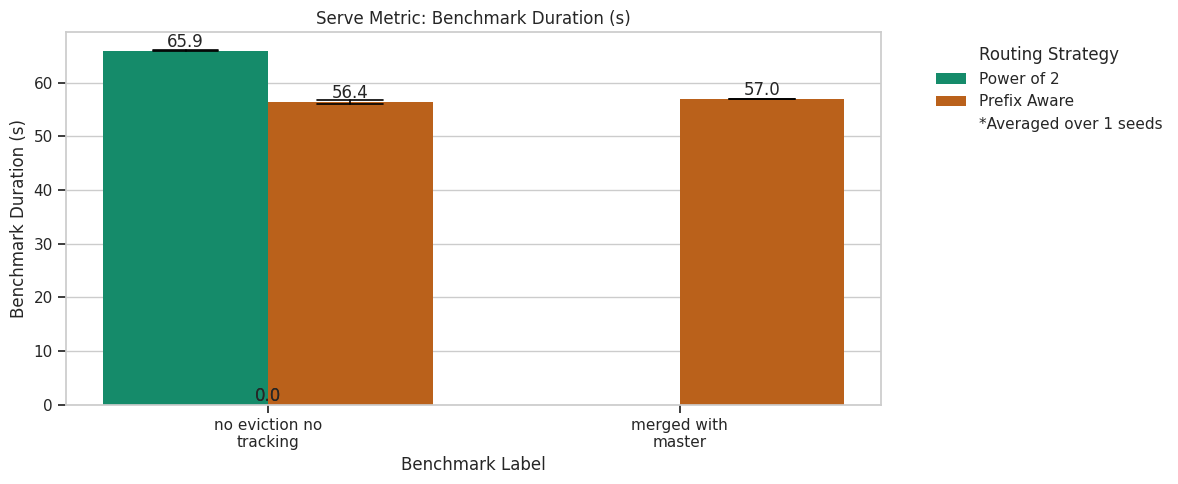

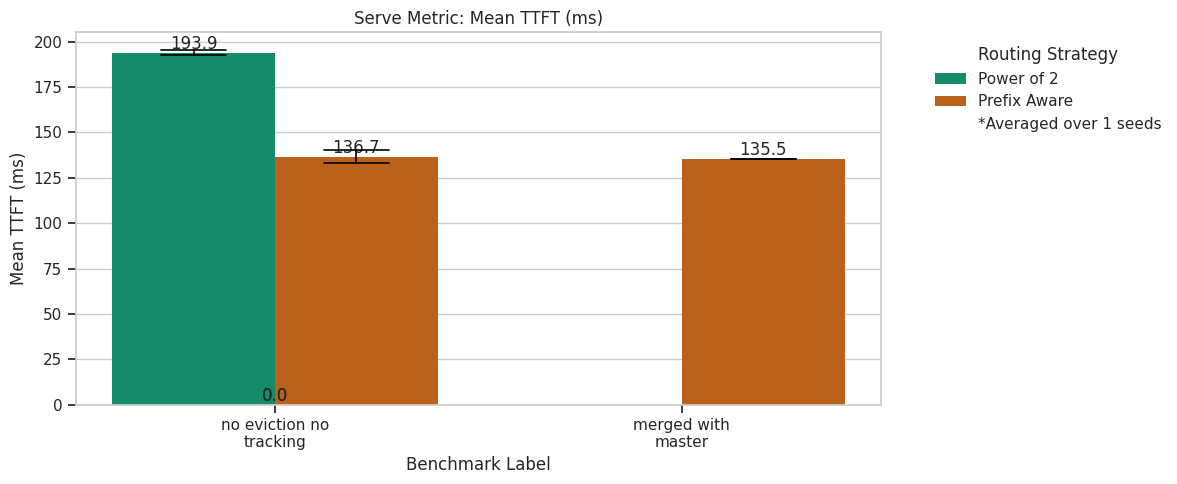

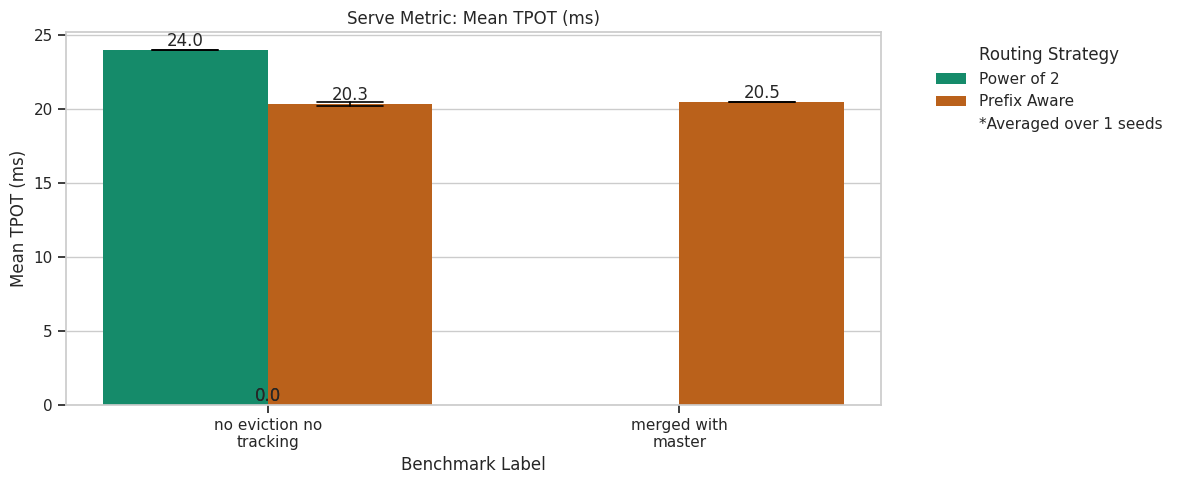

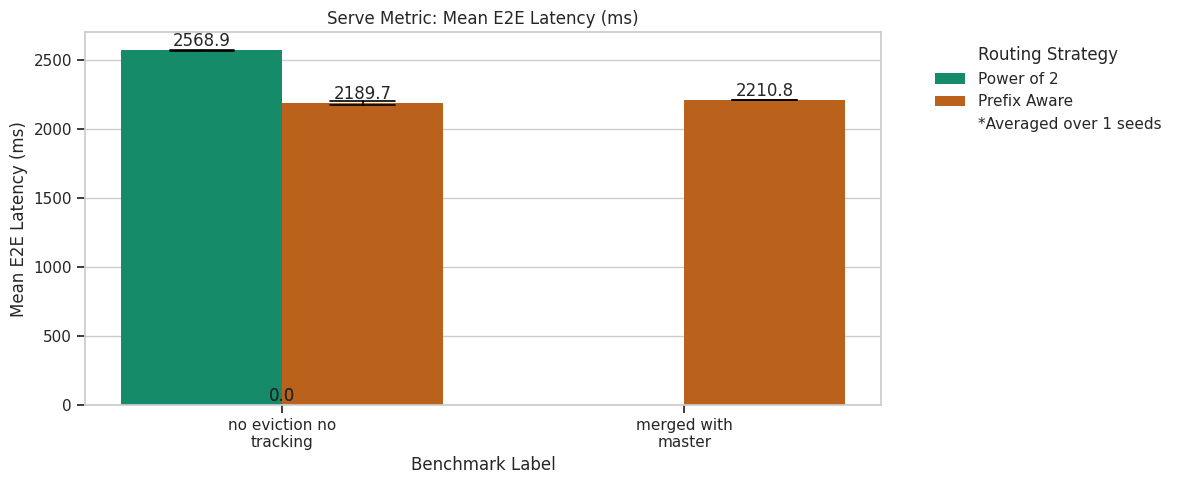

In [40]:
def plot_serve_metric_summary(file_name, metric):
    df = pd.read_csv(file_name)
    df = df[df["gpu_type"] != "gpu_type"]
    df[metric] = pd.to_numeric(df[metric], errors="raise")

    plt.figure(figsize=(12, 5))

    df["benchmark_label"] = df["benchmark_label"].str.replace("_", " ")
    df["wrapped_label"] = df["benchmark_label"].apply(lambda x: "\n".join(wrap(x, 15)))
    original_label_order = df["wrapped_label"].unique()

    strategy_counts_by_label = df.groupby(["wrapped_label", "routing_strategy"]).size().reset_index(name="count")
    num_seeds = strategy_counts_by_label["count"].min()
    if len(strategy_counts_by_label) == 0:
        num_seeds = -1

    grouped = df.groupby(["wrapped_label", "routing_strategy"])
    avg_df = grouped[metric].mean().reset_index()
    min_df = grouped[metric].min().reset_index()
    max_df = grouped[metric].max().reset_index()

    avg_df = avg_df.merge(min_df, on=["wrapped_label", "routing_strategy"], suffixes=("", "_min"))
    avg_df = avg_df.merge(max_df, on=["wrapped_label", "routing_strategy"], suffixes=("", "_max"))

    # Get unique strategies present in the data
    present_strategies = avg_df["routing_strategy"].unique()
    # Filter STRATEGY_NAMES to only include present strategies
    filtered_strategy_names = {k: v for k, v in STRATEGY_NAMES.items() if k in present_strategies}

    # Create a custom palette that maintains consistent colors for each strategy
    all_strategies = list(STRATEGY_NAMES.keys())
    # Using the colorblind-friendly palette already set above
    palette = sns.color_palette(n_colors=len(all_strategies))
    strategy_to_color = dict(zip(all_strategies, palette))

    # Filter the palette to only include present strategies while maintaining color consistency
    filtered_palette = [strategy_to_color[strategy] for strategy in all_strategies if strategy in present_strategies]

    ax = sns.barplot(
        x="wrapped_label",
        y=metric,
        hue="routing_strategy",
        hue_order=[s for s in all_strategies if s in present_strategies],
        data=avg_df,
        order=original_label_order,
        palette=filtered_palette
    )

    # Match whiskers to exact bars
    bar_map = {}  # (wrapped_label, routing_strategy) -> (x_center, width)
    for p in ax.patches:
        x_center = p.get_x() + p.get_width() / 2.
        width = p.get_width()
        height = p.get_height()
        for _, row in avg_df.iterrows():
            avg_val = row[metric]
            if abs(height - avg_val) < 1e-2:
                key = (row["wrapped_label"], row["routing_strategy"])
                if key not in bar_map:
                    bar_map[key] = (x_center, width)
                break

    # Draw "I"-shaped whiskers
    for _, row in avg_df.iterrows():
        key = (row["wrapped_label"], row["routing_strategy"])
        if key in bar_map:
            x, width = bar_map[key]
            y_min = row[f"{metric}_min"]
            y_max = row[f"{metric}_max"]
            cap_width = width * 0.4

            # Vertical whisker
            ax.plot([x, x], [y_min, y_max], color="black", linewidth=1.2, zorder=5)
            # Top and bottom caps
            ax.plot([x - cap_width / 2, x + cap_width / 2], [y_max, y_max], color="black", linewidth=1.2, zorder=5)
            ax.plot([x - cap_width / 2, x + cap_width / 2], [y_min, y_min], color="black", linewidth=1.2, zorder=5)

    # Value labels on top of each bar
    for p in ax.patches:
        value = p.get_height()
        text = f"{value:.1f}"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., value),
                    ha="center", va="bottom")

    plt.title(f"Serve Metric: {AVAILABLE_SERVE_METRICS[metric]}")
    plt.xlabel("Benchmark Label")
    plt.ylabel(AVAILABLE_SERVE_METRICS[metric])

    handles, labels = ax.get_legend_handles_labels()
    strategy_handles = handles
    strategy_labels = [filtered_strategy_names[label] for label in labels]

    extra_lines = []
    if num_seeds != -1:
        seed_info = f"*Averaged over {num_seeds} seeds"
        extra_lines.append(Line2D([], [], color="none", label=seed_info))

    ax.legend(
        handles=strategy_handles + extra_lines,
        labels=strategy_labels + [line.get_label() for line in extra_lines],
        title="Routing Strategy",
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

    plt.tight_layout()
    plt.show()

for metric in AVAILABLE_SERVE_METRICS:
    plot_serve_metric_summary("/home/ray/default/work/ray/_benchmarking_scripts/csv_results/serve_chosen_sweep_results.csv", metric)

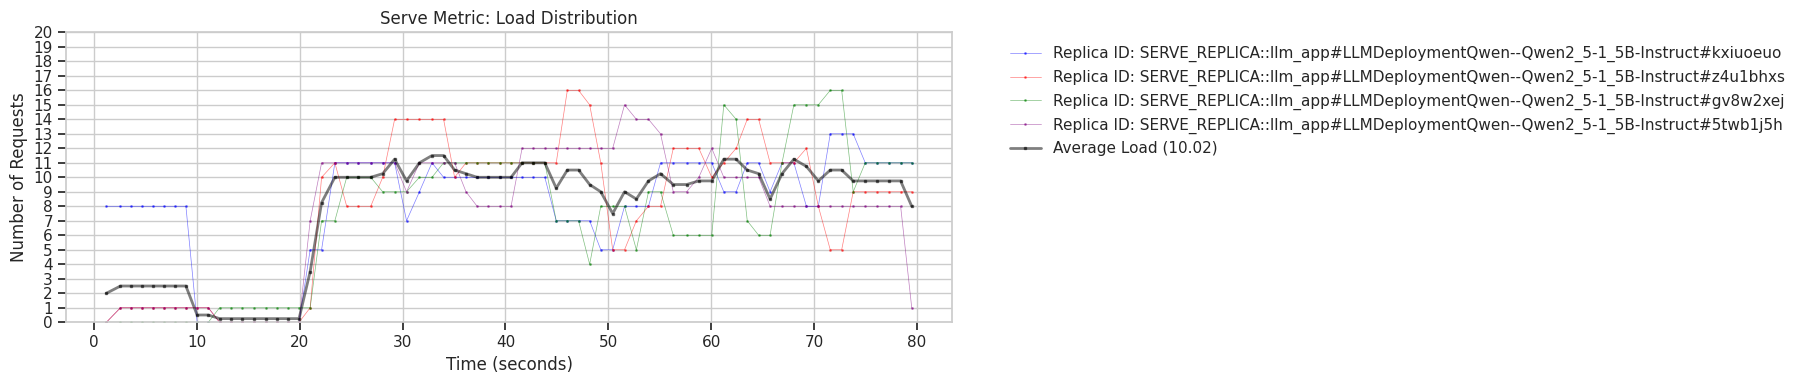

In [41]:
def plot_serve_load_distribution(json_file_path, title=None):
    """
    Plot the load distribution over time for each replica on a single chart.
    Args:
        json_file_path: Path to the JSON file containing load distribution data
    """

    # Load the data from the JSON file
    with open(json_file_path, "r") as f:
        load_data = json.load(f)

    # Convert the data to a more usable format
    times = sorted([float(t) for t in load_data.keys() if load_data[t]])
    replicas = list(load_data[str(times[0])].keys())

    # Create a single figure with smaller size
    plt.figure(figsize=(12, 4))

    # Define colors for each replica
    colors = ["blue", "red", "green", "purple"]

    # Store all replica loads to calculate average
    all_replica_loads = []

    # Plot each replica's load over time on the same chart
    for i, replica_id in enumerate(replicas):
        if i >= 4:  # Only plot the first 4 replicas
            break

        # Extract data for this replica
        replica_loads = [load_data[str(t)].get(replica_id, 0) for t in times]
        all_replica_loads.append(replica_loads)

        # Plot the data with different color for each replica (more transparent)
        # Using smaller marker size (markersize=4)
        plt.plot(times, replica_loads, marker="o", markersize=1, linestyle="-", linewidth=0.5,
                 color=colors[i], label=f"Replica ID: {replica_id}", alpha=0.5)

    # Calculate and plot the average load
    avg_loads = None
    avg_load_value = 0
    if all_replica_loads:
        avg_loads = np.mean(all_replica_loads, axis=0)

        # Calculate average load during high-load period (when avg > 5)
        if any(load > 5 for load in avg_loads):
            start_idx = next((i for i, load in enumerate(avg_loads) if load > 5), 0)
            end_idx = len(avg_loads) - next((i for i, load in enumerate(reversed(avg_loads)) if load > 5), 0) - 1
            if start_idx <= end_idx:
                high_load_window = avg_loads[start_idx:end_idx+1]
                avg_load_value = np.mean(high_load_window) if high_load_window.size > 0 else 0

        plt.plot(times, avg_loads, marker="s", markersize=2, linestyle="-", linewidth=2,
                 color="black", label=f"Average Load ({avg_load_value:.2f})", alpha=0.5, zorder=10)
    if title is not None:
        plot_title = f"Serve Metric: Load Distribution – {title}"
    else:
        plot_title = "Serve Metric: Load Distribution"

    plt.title(plot_title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of Requests")
    plt.grid(True)
    # Place legend outside the plot to avoid overlapping with lines

    # Real legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    # Draw final legend
    plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc="upper left")

    # Set y-axis to integers from 0 to 20 inclusive
    ax = plt.gca()
    ax.set_ylim(0, 20)
    ax.yaxis.set_major_locator(MultipleLocator(1))

    # Make sure the ticks are visible
    ax.tick_params(axis="y", which="major", length=6)

    # Adjust layout to make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)
    plt.show()

plot_serve_load_distribution("/home/ray/default/work/ray/_benchmarking_scripts/custom_results/load_distribution/prefix_aware.json")

/tmp/ipykernel_54919/3865054043.py:128: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


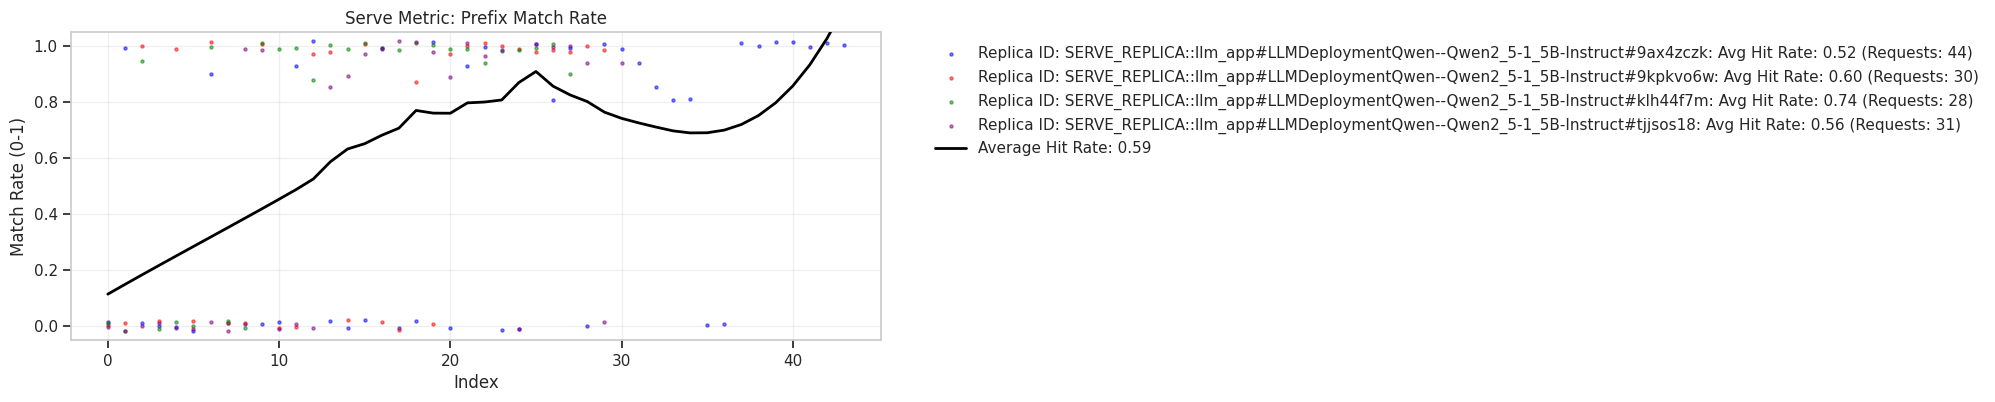

In [42]:
def plot_serve_prefix_match_rate(csv_file_path, title=None):
    """
    Plot the prefix match rates for each replica on a single chart.
    Args:
        csv_file_path: Path to the CSV file containing prefix match rates data
        title: Optional title for the plot
    """
    # Read CSV data
    df = pd.read_csv(csv_file_path)

    # Group data by replica_id and time
    grouped = df.groupby("replica_id")

    # Create a figure
    plt.figure(figsize=(12, 4))

    # Define colors for different replicas
    colors = ["blue", "red", "green", "purple", "orange", "brown", "pink", "gray"]

    # Store all match rates for calculating average
    all_match_rates = []
    max_length = 0

    # Plot each replica's match rates
    for i, (replica_id, group) in enumerate(grouped):
        # Sort by time
        group = group.sort_values("time")
        match_rates = group["match_rate"].values

        # Create indices for x-axis (0 to len(match_rates)-1)
        indices = np.arange(len(match_rates))

        # Track the maximum length for average calculation
        max_length = max(max_length, len(match_rates))

        # Store match rates for average calculation
        all_match_rates.append(match_rates)

        # Apply jitter for zero values based on replica index
        jittered_match_rates = []
        for rate in match_rates:
            jittered_match_rates.append(rate + random.uniform(-0.02, 0.02))

        # Calculate replica-specific statistics
        replica_avg_rate = np.mean(match_rates) if match_rates.size > 0 else 0
        num_requests = len(match_rates)

        # Plot the data points with enhanced legend
        plt.scatter(indices, jittered_match_rates,
                   color=colors[i % len(colors)],
                   alpha=0.5,
                   s=5,  # smaller point size
                   label=f"Replica ID: {replica_id}: Avg Hit Rate: {replica_avg_rate:.2f} (Requests: {num_requests})")

    # Calculate the overall average hit rate across all data points
    all_rates = []
    for rates in all_match_rates:
        all_rates.extend(rates)
    overall_avg_rate = np.mean(all_rates) if all_rates else 0

    # Calculate and plot the average hit rate
    if all_match_rates:
        # Pad shorter arrays with NaN to make them all the same length
        padded_rates = []
        for rates in all_match_rates:
            if len(rates) < max_length:
                # Convert rates to list if it's a numpy array
                rates_list = rates.tolist() if isinstance(rates, np.ndarray) else list(rates)
                # Create padding list
                padding = [np.nan] * (max_length - len(rates_list))
                # Concatenate lists
                padded = rates_list + padding
                padded_rates.append(padded)
            else:
                padded_rates.append(rates)

        # Convert to numpy array and calculate average, ignoring NaN values
        avg_rates = np.nanmean(padded_rates, axis=0)

        # Smooth the average line using Savitzky-Golay filter
        # Only apply smoothing if we have enough data points
        if max_length > 10:
            window_length = min(max_length // 4 * 2 + 1, 51)  # Must be odd and less than data length
            window_length = max(5, window_length)  # At least 5
            polyorder = min(3, window_length - 1)  # Must be less than window_length

            # Replace NaN values with interpolated values for smoothing
            nan_indices = np.isnan(avg_rates)
            if np.any(nan_indices):
                x = np.arange(len(avg_rates))
                avg_rates_no_nan = avg_rates.copy()
                avg_rates_no_nan[nan_indices] = np.interp(
                    x[nan_indices], x[~nan_indices], avg_rates[~nan_indices]
                )
                smoothed_avg = savgol_filter(avg_rates_no_nan, window_length, polyorder)
            else:
                smoothed_avg = savgol_filter(avg_rates, window_length, polyorder)

            # Plot the smoothed average line with average hit rate in the legend
            plt.plot(np.arange(max_length), smoothed_avg,
                     color="black",
                     linewidth=2,
                     label=f"Average Hit Rate: {overall_avg_rate:.2f}",
                     zorder=10)
        else:
            # If not enough data points for smoothing, plot the original average
            plt.plot(np.arange(max_length), avg_rates,
                     color="black",
                     linewidth=2,
                     label=f"Average Hit Rate: {overall_avg_rate:.2f}",
                     zorder=10)

    # Set plot title and labels
    plt.title(f"Serve Metric: Prefix Match Rate - {title}" if title else "Serve Metric: Prefix Match Rate")
    plt.xlabel("Index")
    plt.ylabel("Match Rate (0-1)")

    # Set y-axis limits
    plt.ylim(-0.05, 1.05)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)

    plt.show()

plot_serve_prefix_match_rate("/home/ray/default/work/ray/_benchmarking_scripts/custom_results/prefix_match_rate/prefix_aware.csv")

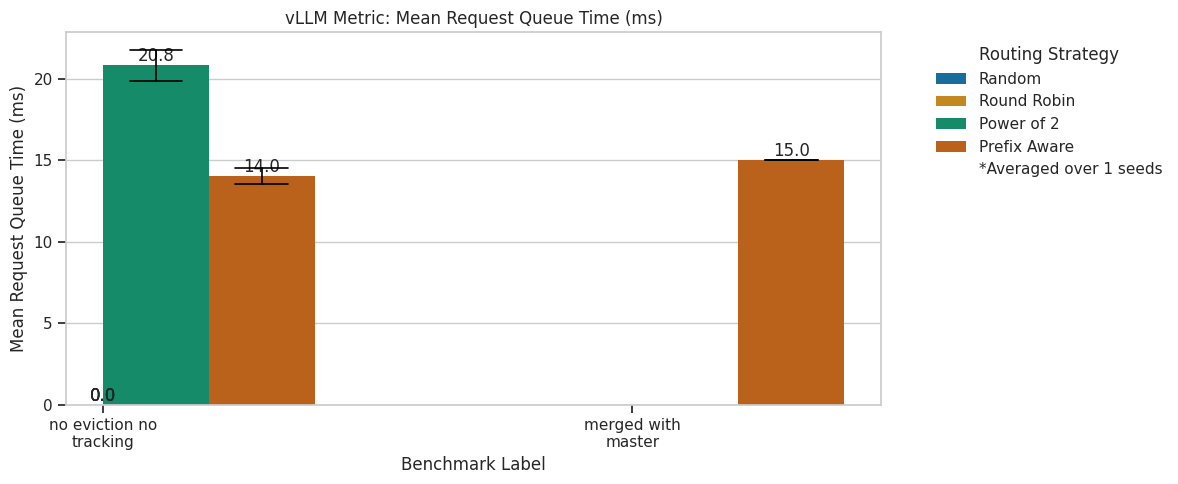

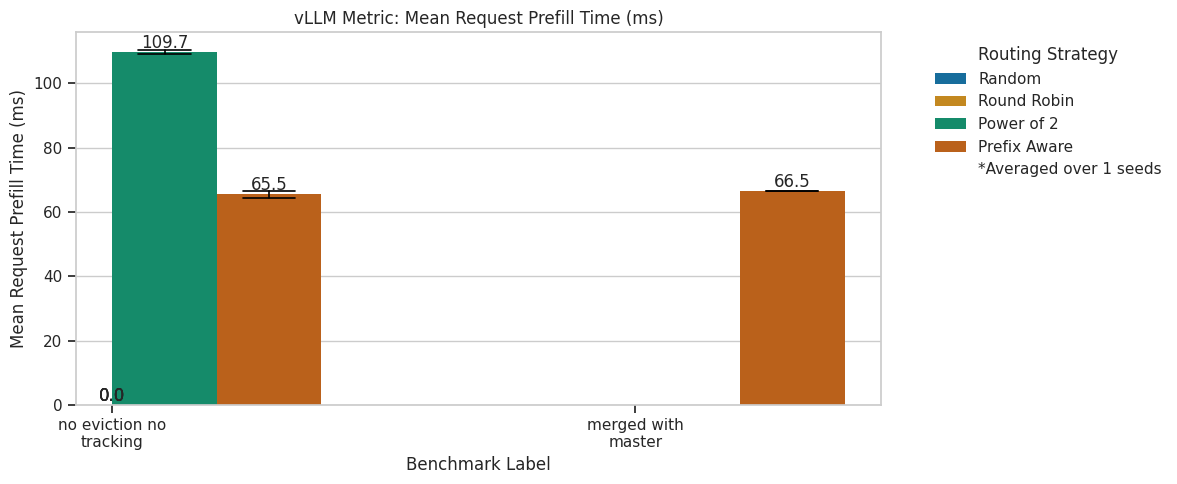

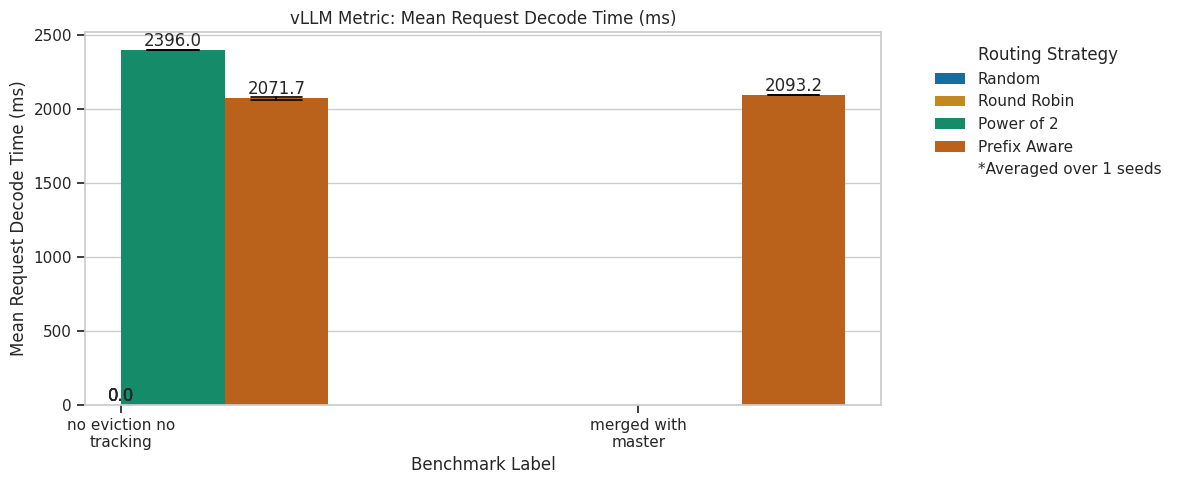

In [43]:
def plot_vllm_metric_summary(file_name, metric):
    """
    Plot a vLLM metric from the CSV file for the given metric, with min-max whiskers.
    Args:
        file_name: Path to the CSV file containing vLLM sweep results.
        metric: A string matching one of the vLLM metric column names
                (e.g., "ray_vllm:time_to_first_token_seconds").
    """
    # Read CSV data
    df = pd.read_csv(file_name)
    df = df[df["gpu_type"] != "gpu_type"]
    df[metric] = pd.to_numeric(df[metric], errors="raise")
    if metric.endswith("seconds"):
        df[metric] = df[metric] * 1000

    plt.figure(figsize=(12, 5))

    df["benchmark_label"] = df["benchmark_label"].str.replace("_", " ")
    df["wrapped_label"] = df["benchmark_label"].apply(lambda x: "\n".join(wrap(x, 15)))
    original_label_order = df["wrapped_label"].unique()

    strategy_counts_by_label = df.groupby(["wrapped_label", "routing_strategy"]).size().reset_index(name="count")
    num_seeds = strategy_counts_by_label["count"].min()
    if len(strategy_counts_by_label) == 0:
        num_seeds = -1

    grouped = df.groupby(["wrapped_label", "routing_strategy"])
    avg_df = grouped[metric].mean().reset_index()
    min_df = grouped[metric].min().reset_index()
    max_df = grouped[metric].max().reset_index()

    avg_df = avg_df.merge(min_df, on=["wrapped_label", "routing_strategy"], suffixes=("", "_min"))
    avg_df = avg_df.merge(max_df, on=["wrapped_label", "routing_strategy"], suffixes=("", "_max"))

    ax = sns.barplot(
        x="wrapped_label",
        y=metric,
        hue="routing_strategy",
        hue_order=STRATEGY_NAMES.keys(),
        data=avg_df,
        order=original_label_order
    )

    bar_width = ax.patches[0].get_width()
    cap_width = bar_width * 0.5  # Cap spans 50% of the bar width

    # Match whiskers to exact bar positions
    bar_map = {}  # (wrapped_label, routing_strategy) -> bar center x
    for p in ax.patches:
        x_center = p.get_x() + bar_width / 2.
        height = p.get_height()
        # Try to match this patch to the correct group in avg_df
        for _, row in avg_df.iterrows():
            avg_val = row[metric]
            if abs(height - avg_val) < 1e-2:
                key = (row["wrapped_label"], row["routing_strategy"])
                if key not in bar_map:
                    bar_map[key] = x_center
                break

    # Draw whiskers
    for _, row in avg_df.iterrows():
        key = (row["wrapped_label"], row["routing_strategy"])
        if key in bar_map:
            x = bar_map[key]
            y_min = row[f"{metric}_min"]
            y_max = row[f"{metric}_max"]
            ax.plot([x, x], [y_min, y_max], color="black", linewidth=1.2, zorder=5)

            # Top cap at max
            ax.plot([x - cap_width / 2, x + cap_width / 2], [y_max, y_max], color="black", linewidth=1.2, zorder=5)
            # Bottom cap at min
            ax.plot([x - cap_width / 2, x + cap_width / 2], [y_min, y_min], color="black", linewidth=1.2, zorder=5)

    # Add value labels
    for p in ax.patches:
        value = p.get_height()
        label_text = f"{value:.1f}"
        ax.annotate(
            label_text,
            (p.get_x() + p.get_width() / 2., value),
            ha="center",
            va="bottom"
        )

    plt.title(f"vLLM Metric: {VLLM_BENCHMARK_METRICS[metric]}")
    plt.xlabel("Benchmark Label")
    plt.ylabel(VLLM_BENCHMARK_METRICS[metric])

    handles, labels = ax.get_legend_handles_labels()
    strategy_handles = handles
    strategy_labels = [STRATEGY_NAMES[label] for label in labels]

    extra_lines = []
    if num_seeds != -1:
        seed_info = f"*Averaged over {num_seeds} seeds"
        extra_lines.append(Line2D([], [], color="none", label=seed_info))

    ax.legend(
        handles=strategy_handles + extra_lines,
        labels=strategy_labels + [line.get_label() for line in extra_lines],
        title="Routing Strategy",
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

    plt.tight_layout()
    plt.show()

for metric in VLLM_BENCHMARK_METRICS:
    plot_vllm_metric_summary("/home/ray/default/work/ray/_benchmarking_scripts/csv_results/vllm_chosen_sweep_results.csv", metric)

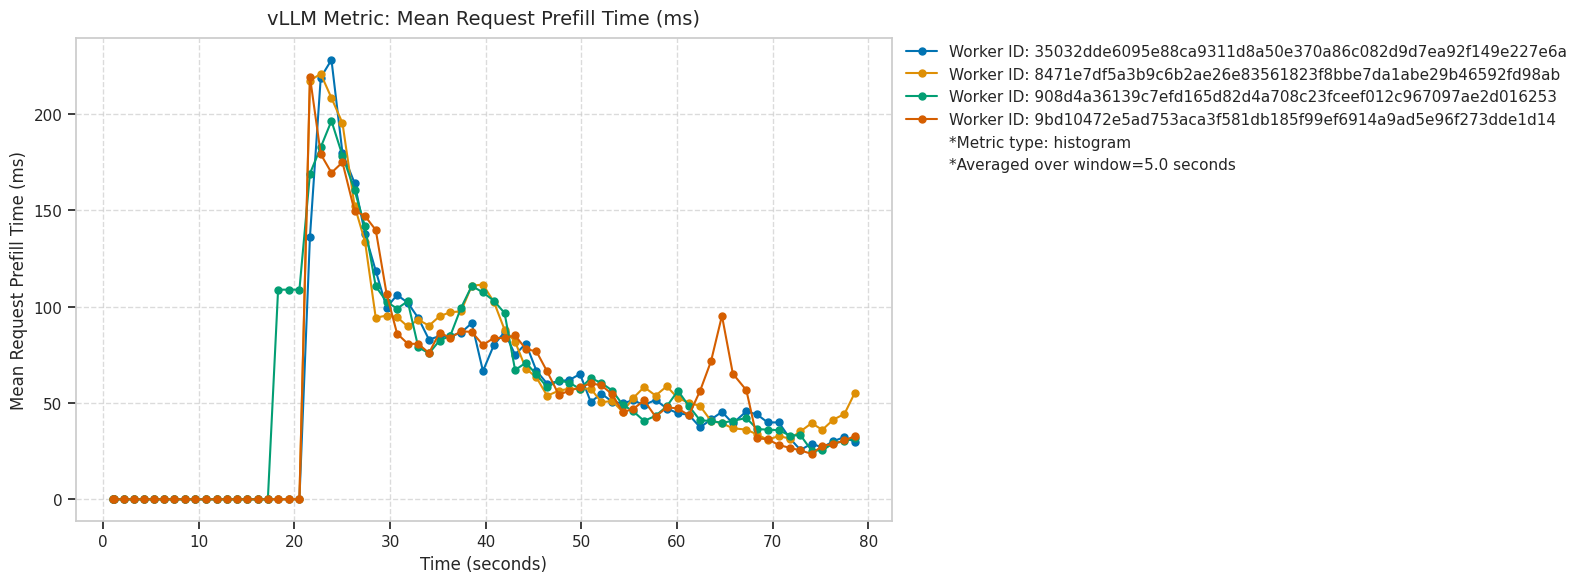

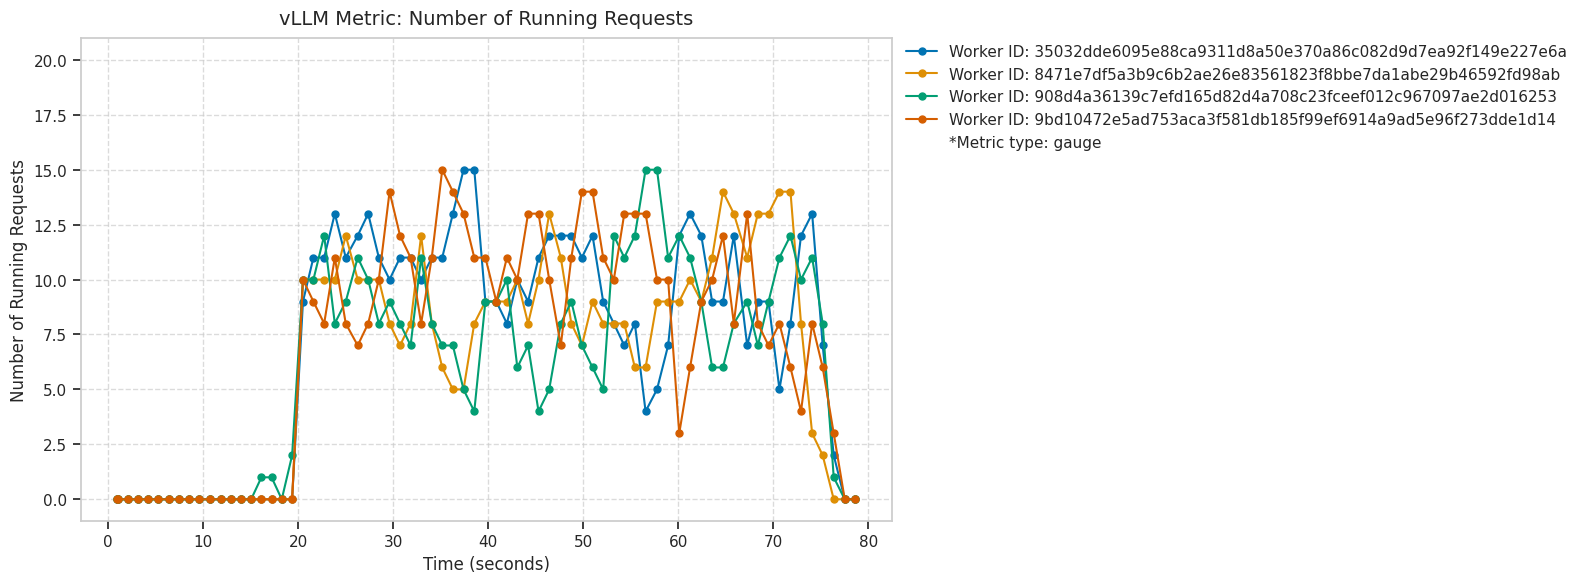

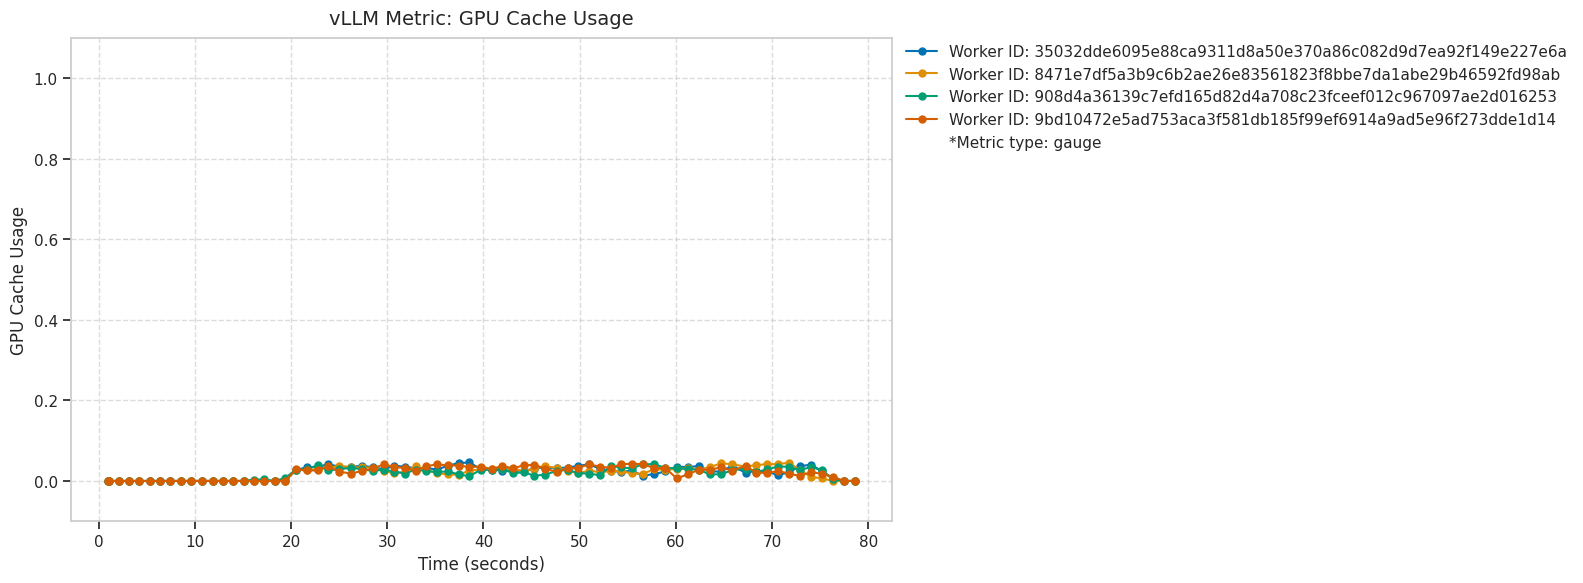

In [44]:
def plot_vllm_metric_timeseries(
    json_file_path: str,
    metric_name: str,
    title: Optional[str] = None,
    window_sec: Optional[float] = 5.0
):
    """
    Generalized vLLM metric plotter with improved styling.
    Args:
        json_file_path: Path to the JSON file with vLLM metrics.
        metric_name: Metric name (e.g. 'ray_vllm:gpu_cache_usage_perc' or base name like 'time_to_first_token_seconds').
        title: Optional plot title.
        window_sec: Window size in seconds for moving average (only applies for histogram metrics).
    """
    is_histogram = VLLM_METRIC_TYPES.get(metric_name, "unknown") == "histogram"

    # Load metric data from JSON file
    with open(json_file_path, "r") as f:
        raw_data = json.load(f)

    # Convert timestamp strings to float and sort them
    times = sorted([float(t) for t in raw_data.keys()])

    all_replica_metrics = []

    # Count how many times each replica appears across all timestamps
    worker_counts = {}
    for t in raw_data:
        for rid in raw_data[t]:
            worker_counts[rid] = worker_counts.get(rid, 0) + 1

    # Only keep replicas that appear in more than 75% of timestamps
    min_appearance = len(times) * 0.75
    valid_replicas = {rid for rid, count in worker_counts.items() if count > min_appearance}

    # Filter replicas that contain the specified metric
    replica_ids = set()
    for t in raw_data:
        for rid in raw_data[t]:
            if rid not in valid_replicas:
                continue
            keys = raw_data[t][rid].keys()

            if is_histogram:
                match_prefix_sum = [k for k in keys if matches_vllm_metric_name(k, metric_name, "_sum")]
                match_prefix_count = [k for k in keys if matches_vllm_metric_name(k, metric_name, "_count")]

                if match_prefix_sum and match_prefix_count:
                    replica_ids.add(rid)
            else:
                match_prefix = [k for k in keys if matches_vllm_metric_name(k, metric_name)]

                if match_prefix:
                    replica_ids.add(rid)

    replica_ids = sorted(replica_ids)

    if not replica_ids:
        print("[WARN] No matching replicas found.")
        return

    # Create figure with improved styling
    plt.figure(figsize=(12, 6))

    # Add grid with dotted lines for all x and y axis ticks
    plt.grid(True, linestyle="--", alpha=0.7)

    for i, replica_id in enumerate(replica_ids):
        y_vals = []
        for current_time in times:
            current_snapshot = raw_data.get(str(current_time), {}).get(replica_id, {})

            if is_histogram:
                # Find current sum and count
                current_sum = next((v for k, v in current_snapshot.items() if matches_vllm_metric_name(k, metric_name, "_sum")), 0)
                current_count = next((v for k, v in current_snapshot.items() if matches_vllm_metric_name(k, metric_name, "_count")), 0)
                if window_sec:
                    # Compute moving average over a specified time window
                    window_start = current_time - window_sec

                    # Find the first timestamp that is >= window_start
                    start_time = times[0]  # Default to first timestamp
                    for time in times:
                        if time >= window_start:
                            start_time = time
                            break

                    # If there's not enough data for a window, skip
                    if start_time == current_time:
                        y_vals.append(0.0)
                        continue

                    start_snapshot = raw_data.get(str(start_time), {}).get(replica_id, {})

                    # Calculate the sum and count differences over the window
                    start_sum = next((v for k, v in start_snapshot.items() if matches_vllm_metric_name(k, metric_name, "_sum")), 0)
                    start_count = next((v for k, v in start_snapshot.items() if matches_vllm_metric_name(k, metric_name, "_count")), 0)

                    # Compute average value for the window
                    sum_diff = current_sum - start_sum
                    count_diff = current_count - start_count
                    running_avg = (sum_diff / count_diff) if count_diff > 0 else 0.0
                    y_vals.append(running_avg)
                else:
                    # Compute running average with window_sec = infinity
                    current_avg = current_sum / current_count if current_count > 0 else 0.0
                    y_vals.append(current_avg)
            else:
                # For raw metrics, just extract the value directly
                current_val = next((v for k, v in current_snapshot.items() if matches_vllm_metric_name(k, metric_name)), 0)
                y_vals.append(current_val)

        # Warn if the series is all zero (likely invalid or missing data)
        if all(v == 0 for v in y_vals):
            print(f"[WARN] All values are zero for replica {replica_id}.")
        if metric_name.endswith("seconds"):
            y_vals = [v * 1000 for v in y_vals]

        # Plot with larger markers and improved styling
        plt.plot(times, y_vals, marker="o", markersize=5, linestyle="-", linewidth=1.5,
                 color=DEFAULT_COLORS[i % len(DEFAULT_COLORS)], label=f"Worker ID: {replica_id}")

    # Plot the average across all replicas with improved styling
    if all_replica_metrics:
        avg_vals = np.mean(all_replica_metrics, axis=0)
        plt.plot(times, avg_vals, marker="s", markersize=6, linestyle="-", linewidth=2,
                 color="black", label="Average")

    # Format clean title
    formatted_name = ALL_AVAILABLE_VLLM_METRICS[metric_name]

    # Set axis labels
    plt.xlabel("Time (seconds)")
    plt.ylabel(formatted_name)

    plot_title = f"vLLM Metric: {formatted_name}"
    if title:
        plot_title += f" – {title}"
    plt.title(plot_title, fontsize=14, pad=10)

    # Parse metric type and axis settings
    metric_type = VLLM_METRIC_TYPES.get(metric_name, "unknown")
    y_axis_limits = VLLM_METRIC_SPECIAL_Y_AXIS_LIMITS.get(metric_name)

    # Set y-axis limits
    if y_axis_limits:
        plt.ylim(y_axis_limits)
        if y_axis_limits == [0, 1]:
            plt.yticks(np.linspace(0, 1, num=11))
    elif metric_type == "counter":
        plt.ylim(bottom=0)

    # Legend header: always include metric type
    info_lines = [Line2D([], [], color="none", label=f"*Metric type: {metric_type}")]

    # Add window info only if averaging is enabled
    if is_histogram:
        if window_sec is not None:
            window_label = f"*Averaged over window={window_sec} seconds"
        else:
            window_label = "*Averaged over window=infinity"
        info_lines.append(Line2D([], [], color="none", label=window_label))

    # Combine dummy + real legend entries
    real_lines, real_labels = plt.gca().get_legend_handles_labels()
    plt.legend(
        handles=real_lines+info_lines,
        loc="upper left",
        bbox_to_anchor=(1.01, 1.0),
        borderaxespad=0.
    )

    # Use plain style for y-axis (no scientific notation)
    plt.ticklabel_format(axis="y", style="plain")

    plt.tight_layout()
    plt.subplots_adjust(right=0.75)

    return plt.gcf()

for metric in ["ray_vllm:request_prefill_time_seconds", "ray_vllm:num_requests_running", "ray_vllm:gpu_cache_usage_perc"]:
    plot_vllm_metric_timeseries("/home/ray/default/work/ray/_benchmarking_scripts/custom_results/vllm_metrics/prefix_aware.json", metric)


In [45]:
def plot_deployment_overhead(json_file_path, title=None):
    # First, parse the data:
    # Define the stages as they appear in the logs
    phase_definitions = [
        {"name": "prefix_match_router_to_deployment", "start": "before_calling_prefix_match", "end": "received_by_prefix_match"},
        {"name": "prefix_match_processing", "start": "received_by_prefix_match", "end": "completed_prefix_match"},
        {"name": "prefix_match_deployment_to_router", "start": "completed_prefix_match", "end": "after_calling_prefix_match"},
        {"name": "prefix_match_total", "start": "before_calling_prefix_match", "end": "after_calling_prefix_match"},
        {"name": "insert_router_to_deployment", "start": "before_calling_insert", "end": "received_by_insert"},
        {"name": "insert_processing", "start": "received_by_insert", "end": "completed_insert"},
        {"name": "insert_deployment_to_router", "start": "completed_insert", "end": "after_calling_insert"},
        {"name": "insert_total", "start": "before_calling_insert", "end": "after_calling_insert"},
        {"name": "total_request_time", "start": "before_calling_prefix_match", "end": "after_calling_insert"},
    ]

    # Read the data directly since each line contains all stages for a request
    request_data = []
    with open(json_file_path, "r") as f:
        for line in f:
            entry = json.loads(line.strip())
            request_data.append(entry)

    # Calculate durations for each phase
    durations = {phase["name"]: [] for phase in phase_definitions}
    for entry in request_data:
        for phase in phase_definitions:
            start, end = phase["start"], phase["end"]
            if start in entry and end in entry:
                durations[phase["name"]].append(entry[end] - entry[start])

    # Second, plot the data
    phase_descriptions = {
        "prefix_match_router_to_deployment": "Router to Deployment",
        "prefix_match_processing": "Processing",
        "prefix_match_deployment_to_router": "Deployment to Router",
        "prefix_match_total": "Total Round Trip",
        "insert_router_to_deployment": "Router to Deployment",
        "insert_processing": "Processing",
        "insert_deployment_to_router": "Deployment to Router",
        "insert_total": "Total Round Trip",
        "total_request_time": "Complete Operation"
    }

    # Detailed chart
    plt.figure(figsize=(12, 5))
    detailed_phases = [
        "prefix_match_router_to_deployment", "prefix_match_processing", "prefix_match_deployment_to_router",
        "insert_router_to_deployment", "insert_processing", "insert_deployment_to_router"
    ]
    detailed_labels = [phase_descriptions[p] + f" ({p.split('_')[0].capitalize()})" for p in detailed_phases]
    detailed_durations = [np.mean(durations[p]) * 1000 for p in detailed_phases if p in durations and durations[p]]

    # Calculate the total as sum of all other bars
    total_duration = sum(detailed_durations)
    detailed_labels.append("Total")
    detailed_durations.append(total_duration)

    # Colors for the bars - blue for prefix match, orange for insert, green for total
    colors = ["#1f77b4"] * 3 + ["#ff7f0e"] * 3 + ["#2ca02c"]

    # Get number of requests
    num_requests = len(next(iter(durations.values()))) if durations else 0

    bars = plt.bar(detailed_labels, detailed_durations, color=colors)
    for bar, duration in zip(bars, detailed_durations):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f"{duration:.2f} ms", ha="center")

    plt.title(f'Deployment Overhead Breakdown ({num_requests} requests){" - " + title if title else ""}')
    plt.ylabel("Duration (ms)")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

In [46]:
def count_routing_matches(title, log_file):
    # Read the CSV file
    df = pd.read_csv(log_file)

    # Print the title
    print(title)

    # Group by routing_decision and count matches
    for decision, group in df.groupby("routing_decision"):
        matches = sum(group["original_request_id"] == group["matched_replica_request_id"])
        total = len(group)
        print(f"{decision}: {matches}/{total} matches")
    print()

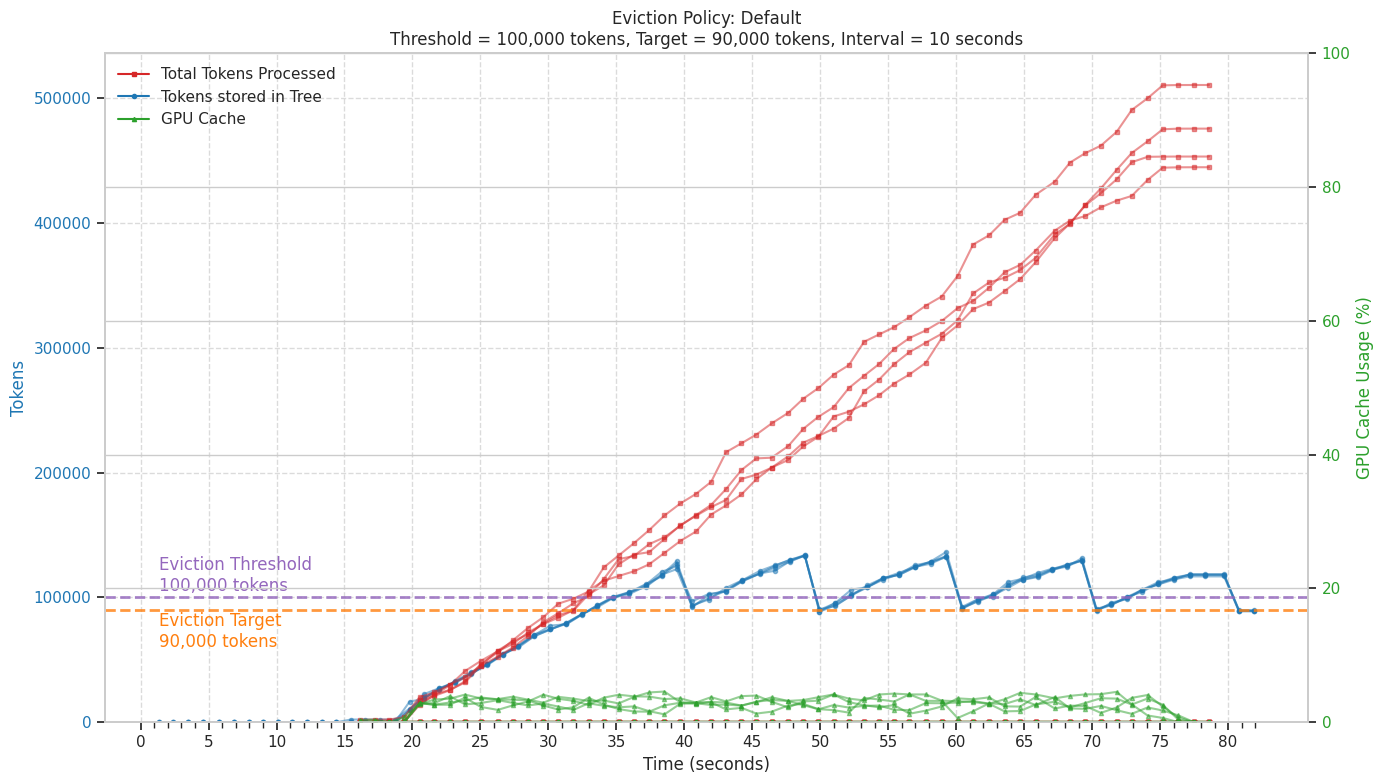

In [47]:
def plot_eviction_policy(char_count_file_path, vllm_metrics_file_path, eviction_threshold_chars, eviction_target_chars, interval_secs, title):
    import json
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    # Read the character count JSON file
    with open(char_count_file_path, "r") as f:
        char_count_data = json.load(f)

    # Read the vLLM metrics JSON file
    with open(vllm_metrics_file_path, "r") as f:
        vllm_metrics_data = json.load(f)

    # Process character count data
    char_count_df_list = []
    for timestamp, replica_data in char_count_data.items():
        for replica_id, char_count in replica_data.items():
            char_count_df_list.append({
                "timestamp": float(timestamp),
                "replica": replica_id,
                "char_count": char_count
            })

    char_count_df = pd.DataFrame(char_count_df_list)
    char_count_df = char_count_df.sort_values("timestamp")

    # Normalize character count by dividing by 4 to approximate tokens
    char_count_df["approx_tokens"] = char_count_df["char_count"] / 4

    # Find the first timestamp where character count becomes non-zero
    first_nonzero_time = char_count_df[char_count_df["approx_tokens"] > 0]["timestamp"].min()

    # Process vLLM metrics data
    metrics_df_list = []

    for timestamp in sorted([float(t) for t in vllm_metrics_data.keys()]):
        timestamp_str = str(timestamp)
        snapshot = vllm_metrics_data[timestamp_str]

        for replica_id, metrics in snapshot.items():
            # Extract metrics for each replica
            prompt_tokens = next((v for k, v in metrics.items()
                                if "ray_vllm:prompt_tokens" in k), 0)
            generation_tokens = next((v for k, v in metrics.items()
                                    if "ray_vllm:generation_tokens" in k), 0)
            gpu_cache = next((v for k, v in metrics.items()
                            if "ray_vllm:gpu_cache_usage_perc" in k), 0)

            # Only include metrics after the first non-zero character count
            if timestamp >= first_nonzero_time:
                metrics_df_list.append({
                    "timestamp": timestamp,
                    "replica": replica_id,
                    "prompt_tokens": prompt_tokens,
                    "generation_tokens": generation_tokens,
                    "gpu_cache_usage": gpu_cache
                })

    metrics_df = pd.DataFrame(metrics_df_list)
    metrics_df["total_tokens"] = metrics_df["prompt_tokens"] + metrics_df["generation_tokens"]

    # Create figure with three y-axes
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Set up colors
    color1 = "tab:blue"
    color2 = "tab:red"
    color3 = "tab:green"
    color4 = "tab:purple"
    color5 = "tab:orange"

    # Plot approximate tokens for each replica
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Tokens", color=color1)

    # Create custom legend handles
    tree_line = ax1.plot([], [], color=color1, marker="o", markersize=3, linestyle="-", label="Tokens stored in Tree")[0]
    total_line = ax1.plot([], [], color=color2, marker="s", markersize=3, linestyle="-", label="Total Tokens Processed")[0]
    gpu_line = ax1.plot([], [], color=color3, marker="^", markersize=3, linestyle="-", label="GPU Cache")[0]

    # Plot actual data with alpha but no labels
    for replica, group in char_count_df.groupby("replica"):
        ax1.plot(group["timestamp"], group["approx_tokens"],
                marker="o", markersize=3, linestyle="-", color=color1, alpha=0.5)

    for replica, group in metrics_df.groupby("replica"):
        ax1.plot(group["timestamp"], group["total_tokens"],
                marker="s", markersize=3, linestyle="-", color=color2, alpha=0.5)

    ax1.tick_params(axis="y", labelcolor=color1)

    # Plot eviction threshold and target lines
    x_min = char_count_df["timestamp"].min()
    x_max = char_count_df["timestamp"].max()
    threshold_tokens = eviction_threshold_chars / 4
    target_tokens = eviction_target_chars / 4

    # Plot threshold and target lines with increased visibility
    ax1.axhline(y=threshold_tokens, color=color4, linestyle="--",
                               linewidth=2, alpha=0.8)
    ax1.axhline(y=target_tokens, color=color5, linestyle="--",
                            linewidth=2, alpha=0.8)

    # Add labels on the left side of the graph
    ax1.text(x_min, threshold_tokens + 2000, f"Eviction Threshold\n{threshold_tokens:,.0f} tokens",
             color=color4, va="bottom", ha="left")
    ax1.text(x_min, target_tokens - 2000, f"Eviction Target\n{target_tokens:,.0f} tokens",
             color=color5, va="top", ha="left")

    # Create third y-axis for GPU cache usage
    ax3 = ax1.twinx()
    ax3.set_ylabel("GPU Cache Usage (%)", color=color3)

    for replica, group in metrics_df.groupby("replica"):
        ax3.plot(group["timestamp"], group["gpu_cache_usage"] * 100,
                marker="^", markersize=3, linestyle="-", color=color3, alpha=0.5)

    ax3.tick_params(axis="y", labelcolor=color3)
    ax3.set_ylim(0, 100)  # Set GPU cache usage scale from 0-100%

    # Set y-axis minimum to 0 for tokens
    ax1.set_ylim(bottom=0)

    # Add grid
    ax1.grid(True, linestyle="--", alpha=0.7)

    # Add legend with custom handles
    ax1.legend(handles=[total_line, tree_line, gpu_line], loc="upper left")

    # Format y-axes with plain style (no scientific notation)
    ax1.ticklabel_format(axis="y", style="plain")

    # Set x-axis ticks to show every 10 seconds with minor ticks every second
    # Start at first multiple of 5 greater than x_min
    start_tick = np.floor(x_min / 5) * 5
    ax1.set_xticks(np.arange(start_tick, x_max + 1, 5))
    ax1.set_xticks(np.arange(start_tick, x_max + 1, 1), minor=True)

    # Extract filenames for the plot title
    plt.title(f"Eviction Policy: {title}\nThreshold = {eviction_threshold_chars/4:,.0f} tokens, Target = {eviction_target_chars/4:,.0f} tokens, Interval = {interval_secs} seconds")

    plt.tight_layout()

plot_eviction_policy("/home/ray/default/work/ray/_benchmarking_scripts/custom_results/char_count_over_time/eviction_400K_threshold_360K_target.json", "/home/ray/default/work/ray/_benchmarking_scripts/custom_results/vllm_metrics/prefix_aware.json", 400_000, 360_000, 10, "Default")

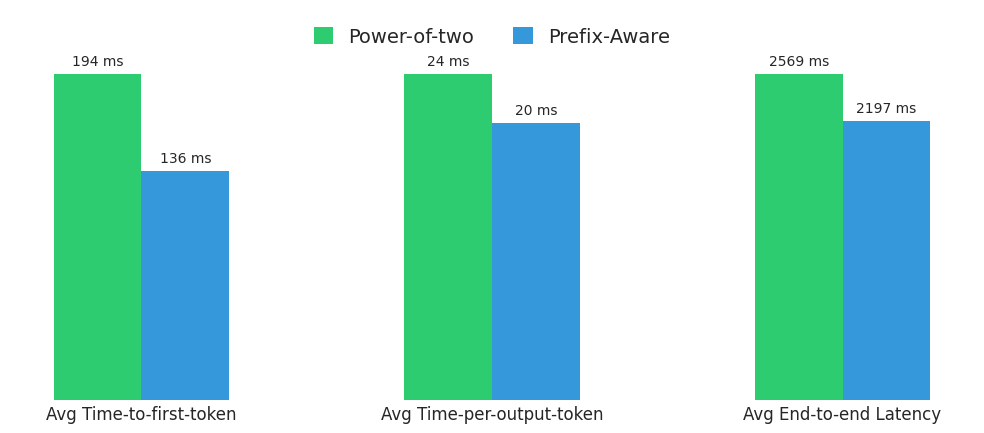

In [48]:
def plot_benchmark_comparison(csv_path: str, title: str = None):
    """
    Plot benchmark metrics comparison between pow2 and prefix-aware strategies.
    Each metric's bars are scaled relative to pow2's height, with actual values labeled.
    Args:
        csv_path: Path to CSV containing benchmark results
        title: Optional title for the plot
    """
    # Read the data
    df = pd.read_csv(csv_path)
    df = df[df["gpu_type"] != "gpu_type"]

    # Calculate mean metrics for each strategy
    metrics = ["mean_ttft_ms", "mean_tpot_ms", "mean_e2e_latency_ms"]  # Reordered metrics
    strategy_means = df.groupby("routing_strategy")[metrics].mean()

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 4.5))

    # Set width of bars
    barWidth = 0.25

    # Set positions of the bars on X axis
    r1 = np.arange(len(metrics))
    r2 = [x + barWidth for x in r1]

    # Get pow2 values and calculate ratios for prefix-aware
    pow2_values = strategy_means.loc["pow_of_2"]
    prefix_values = strategy_means.loc["prefix_aware"]
    ratios = prefix_values / pow2_values

    # Create bars - pow2 all same height (1.0)
    ax.bar(r1, [1.0] * len(metrics), width=barWidth, label="Power-of-two", color="#2ecc71")
    # Prefix-aware bars scaled relative to pow2
    ax.bar(r2, ratios, width=barWidth, label="Prefix-Aware", color="#3498db")

    # Add value labels on top of bars
    for i, (pow2_val, prefix_val) in enumerate(zip(pow2_values, prefix_values)):
        # All metrics are in milliseconds
        pow2_label = f"{pow2_val:.0f} ms"
        prefix_label = f"{prefix_val:.0f} ms"

        ax.text(r1[i], 1.02, pow2_label, ha="center", va="bottom", fontsize=10)  # Smaller font for measurements
        ax.text(r2[i], ratios[i] + 0.02, prefix_label, ha="center", va="bottom", fontsize=10)  # Smaller font for measurements

    # Add labels and title
    # ax.set_xlabel('Metrics')
    if title:
        ax.set_title(title, fontsize=14)

    # Add xticks on the middle of the group bars
    ax.set_xticks([r + barWidth/2 for r in range(len(metrics))])
    ax.set_xticklabels(["Avg Time-to-first-token", "Avg Time-per-output-token", "Avg End-to-end Latency"], fontsize=12)  # Bigger font for labels

    # Add legend underneath title
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.00),  # Adjust this for exact vertical spacing
        ncol=2,  # Puts legend entries side-by-side
        frameon=False,  # Optional: remove border around legend
        fontsize=14,  # Make legend text bigger
        handleheight=1.0,  # Make legend markers square
        handlelength=1.0  # Make legend markers square
    )
    # Remove y-axis since we're using relative heights
    ax.set_yticks([])

    # Set y-axis limits to accommodate labels
    ax.set_ylim(0, 1.2)

    # Remove all spines (borders)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Turn off vertical gridlines and ticks
    ax.grid(False, axis="x")  # Disable x-axis gridlines
    ax.tick_params(axis="x", length=0)  # Remove x-axis tick marks
    ax.tick_params(axis="y", left=False)  # Remove y-axis tick marks

    plt.tight_layout(pad=2.0)

    plt.tight_layout()

plot_benchmark_comparison("/home/ray/default/work/ray/_benchmarking_scripts/csv_results/serve_chosen_sweep_results.csv")